# Time Series Modeling for Crude Oil Price Prediction

This notebook implements and evaluates classical time series models (AR, MA, ARIMA) for predicting crude oil prices. We perform systematic hyperparameter tuning using grid search with AIC/BIC criteria and evaluate each model using rolling one-step-ahead forecasting.

---

# 1. Data Preparation

## 1.1 Library Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

In [2]:
# Load cleaned and shortened oil prediction data (from Data Preprocessing.ipynb)
df = pd.read_csv('../data/shortened_oil_data.csv')
print(f"Data shape: {df.shape}")
df.head()

Data shape: (1229, 468)


,Date,Brent_Oil,USD_CAD,Crude_Oil,DXY,Emerging_Mkt,Gold,Copper,Heating_Oil,Junk_Bond,...,US_Imp_Ethanol,US_Imp_JetFuel,US_Imp_Distillate,US_Imp_Distillate_LowS,US_Imp_Distillate_GT_MedS,US_Imp_Distillate_GT_500_to_2000_ppm_Sulfur,US_Imp_Distillate_GT_2000_ppm_Sulfur,US_Imp_Residual,US_Imp_Propane,US_Imp_Other
0,2021-01-04,51.090000,1.27221,47.619999,89.879997,46.933418,1944.699951,3.5530,1.4620,66.933487,...,0.0,149.0,302.0,257.0,0.0,44.0,0.0,72.0,181.0,384.0
1,2021-01-05,53.599998,1.27810,49.930000,89.440002,48.061630,1952.699951,3.6405,1.5189,66.956551,...,0.0,149.0,302.0,257.0,0.0,44.0,0.0,72.0,181.0,384.0
2,2021-01-06,54.299999,1.26747,50.630001,89.529999,47.655472,1906.900024,3.6500,1.5287,66.833656,...,0.0,149.0,302.0,257.0,0.0,44.0,0.0,72.0,181.0,384.0
3,2021-01-07,54.380001,1.26654,50.830002,89.830002,48.106758,1912.300049,3.6955,1.5381,67.025696,...,0.0,149.0,302.0,257.0,0.0,44.0,0.0,72.0,181.0,384.0
4,2021-01-08,55.990002,1.26838,52.240002,90.099998,49.379372,1834.099976,3.6735,1.5795,67.125595,...,0.0,50.0,346.0,346.0,0.0,0.0,0.0,220.0,149.0,639.0


## 1.2 Feature Selection

We select key indicators based on domain knowledge, including:
- **PADD 3 Metrics**: Gulf Coast refining hub data (net input, production, utilization, stocks)
- **Market Indicators**: Brent oil, DXY, Gold, Natural Gas, S&P 500
- **Technical Indicators**: RSI, MACD, Bollinger Bands, Moving Averages, Volatility
- **Lagged Features**: Previous day prices and returns
- **Supply/Demand Fundamentals**: US stocks, production, imports, exports


In [3]:
# Define target variable
TARGET = 'Crude_Oil'

# Key indicators based on domain knowledge
KEY_INDICATORS = [
    # PADD 3 (Gulf Coast) - major refining hub
    'PADD3_Ref_NetIn_Crude',                              # Refiner Net Input of Crude Oil
    'PADD3_RefBl_NetProd_FinGas',                         # Refiner and Blender Net Production of Finished Motor Gasoline
    'PADD3_Percent_Utilization_Refy_Operable_CapacityPct',# Percent Utilization of Refinery Operable Capacity
    'PADD3_Stocks_Ex_SPR_Crude',                          # Ending Stocks excluding SPR of Crude Oil
    
    # Residual Fuel Oil
    'US_RefBl_NetProd_Residual',                          # U.S. Refiner and Blender Net Production of Residual Fuel Oil
    'US_Stocks_Residual',                                 # U.S. Ending Stocks of Residual Fuel Oil
    
    # US Crude Oil Stocks in Transit from Alaska
    'US_Crude_Stocks_Transit_from_AK',                    # Crude Oil Stocks in Transit from Alaska
    
    # Core market indicators
    'Brent_Oil',           # Brent benchmark
    'DXY',                 # US Dollar Index
    'Gold',                # Safe haven asset
    'Natural_Gas',         # Related energy commodity
    'SP500',               # Market sentiment
    
    # Technical indicators
    'RSI_14',              # Momentum
    'MACD_Hist',           # Trend
    'BB_Position',         # Bollinger position
    'SMA_20',              # Moving average
    'Realized_Vol_20d',    # Volatility
    
    # Lagged features
    'Oil_Lag1',            # Previous day price
    'Oil_Lag2',            # 2-day lag
    'Oil_Lag5',            # Week lag
    'Ret_1d',              # Daily return
    'Ret_5d',              # Weekly return
    
    # Supply/Demand fundamentals
    'US_Stocks_Crude',                                    # U.S. Ending Stocks of Crude Oil
    'US_FieldProd_Crude',                                 # U.S. Field Production of Crude Oil
    'US_Imp_Crude',                                       # U.S. Imports of Crude Oil
    'US_Exp_Crude',                                       # U.S. Exports of Crude Oil
]

# Filter to only columns that exist in the dataframe
feature_cols = [col for col in KEY_INDICATORS if col in df.columns]
missing_cols = [col for col in KEY_INDICATORS if col not in df.columns]

print(f"Target: {TARGET}")
print(f"Selected key features: {len(feature_cols)}")
if missing_cols:
    print(f"Warning - Missing columns: {missing_cols}")

# Prepare data
X = df[feature_cols].values.astype(np.float64)
y = df[TARGET].values.astype(np.float64)

print(f"\nSelected features:")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")


Target: Crude_Oil
Selected key features: 26

Selected features:
  1. PADD3_Ref_NetIn_Crude
  2. PADD3_RefBl_NetProd_FinGas
  3. PADD3_Percent_Utilization_Refy_Operable_CapacityPct
  4. PADD3_Stocks_Ex_SPR_Crude
  5. US_RefBl_NetProd_Residual
  6. US_Stocks_Residual
  7. US_Crude_Stocks_Transit_from_AK
  8. Brent_Oil
  9. DXY
  10. Gold
  11. Natural_Gas
  12. SP500
  13. RSI_14
  14. MACD_Hist
  15. BB_Position
  16. SMA_20
  17. Realized_Vol_20d
  18. Oil_Lag1
  19. Oil_Lag2
  20. Oil_Lag5
  21. Ret_1d
  22. Ret_5d
  23. US_Stocks_Crude
  24. US_FieldProd_Crude
  25. US_Imp_Crude
  26. US_Exp_Crude

X shape: (1229, 26)
y shape: (1229,)


In [4]:
from sklearn.preprocessing import StandardScaler

# Check for NaN/Inf values
print(f"NaN in X: {np.isnan(X).sum()}")
print(f"NaN in y: {np.isnan(y).sum()}")
print(f"Inf in X: {np.isinf(X).sum()}")
print(f"Inf in y: {np.isinf(y).sum()}")

# Replace NaN with column mean and Inf with large finite values
X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
y = np.nan_to_num(y, nan=np.nanmean(y), posinf=1e10, neginf=-1e10)

# Fill remaining NaN with column means
col_means = np.nanmean(X, axis=0)
col_means = np.nan_to_num(col_means, nan=0.0)
for i in range(X.shape[1]):
    mask = np.isnan(X[:, i])
    X[mask, i] = col_means[i]

print(f"After cleaning - NaN in X: {np.isnan(X).sum()}, NaN in y: {np.isnan(y).sum()}")

# Normalize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Replace any remaining NaN/Inf after scaling
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
y_scaled = np.nan_to_num(y_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print(f"X scaled - mean: {X_scaled.mean():.4f}, std: {X_scaled.std():.4f}")
print(f"y scaled - mean: {y_scaled.mean():.4f}, std: {y_scaled.std():.4f}")
print(f"Final NaN check - X: {np.isnan(X_scaled).sum()}, y: {np.isnan(y_scaled).sum()}")


NaN in X: 96
NaN in y: 0
Inf in X: 0
Inf in y: 0
After cleaning - NaN in X: 0, NaN in y: 0
X scaled - mean: 0.0000, std: 1.0000
y scaled - mean: -0.0000, std: 1.0000
Final NaN check - X: 0, y: 0


In [5]:
# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    """Create sequences for LSTM input"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # Predict next day
    return np.array(X_seq), np.array(y_seq)

# Hyperparameters - Fine-tuned for ~27 key features
SEQ_LENGTH = 15   # Moderate sequence length - captures 3 weeks of market patterns
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)
print(f"Sequence X shape: {X_seq.shape}")  # (samples, seq_length, features)
print(f"Sequence y shape: {y_seq.shape}")  # (samples,)


Sequence X shape: (1214, 15, 26)
Sequence y shape: (1214,)


In [6]:
# Time-series split (no shuffle to preserve temporal order)
n_samples = len(X_seq)
train_end = int(n_samples * TRAIN_RATIO)
val_end = int(n_samples * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

print(f"Train set: {X_train.shape[0]} samples")
print(f"Val set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Train set: 849 samples
Val set: 182 samples
Test set: 183 samples


## 1.3 Helper Functions and Naive Baseline

We define utility functions for:
- **Metric Calculation**: MSE, RMSE, MAE, R², MAPE
- **Rolling Forecast**: One-step-ahead prediction to simulate real-world deployment
- **Naive Baseline**: Persistence model (tomorrow's price = today's price) as benchmark


In [7]:
# Helper functions for evaluation
def calculate_metrics(actual, predicted):
    """Calculate regression metrics."""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

def print_metrics(metrics, model_name):
    """Print metrics in formatted style."""
    print(f"\n{model_name} Test Set Metrics:")
    print(f"  MSE:  {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE:  {metrics['MAE']:.4f}")
    print(f"  R²:   {metrics['R2']:.4f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")

def rolling_forecast(train_data, val_data, test_data, order, verbose=True):
    """Perform rolling one-step ahead forecast for ARIMA-family models."""
    predictions = []
    history = list(train_data) + list(val_data)
    
    for t in range(len(test_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]
        predictions.append(forecast)
        history.append(test_data[t])
        
        if verbose and (t + 1) % 50 == 0:
            print(f"  Processed {t+1}/{len(test_data)} samples")
    
    return np.array(predictions)

# Create time series split for classical models
n_total = len(y)
train_end = int(n_total * TRAIN_RATIO)
val_end = int(n_total * (TRAIN_RATIO + VAL_RATIO))

ts_train = y[:train_end]
ts_val = y[train_end:val_end]
ts_test = y[val_end:]

print(f"Time Series Data Split:")
print(f"  Train: {len(ts_train)} samples")
print(f"  Val:   {len(ts_val)} samples")
print(f"  Test:  {len(ts_test)} samples")

# Naive Baseline: predict tomorrow = today's price
naive_predictions = ts_test[:-1]
naive_actual = ts_test[1:]
naive_metrics = calculate_metrics(naive_actual, naive_predictions)

print("\n" + "=" * 70)
print("NAIVE BASELINE (Persistence Model: Tomorrow = Today)")
print("=" * 70)
print_metrics(naive_metrics, "Naive Baseline")
print("\nNote: This represents the 'no-skill' benchmark.")


Time Series Data Split:
  Train: 860 samples
  Val:   184 samples
  Test:  185 samples

NAIVE BASELINE (Persistence Model: Tomorrow = Today)

Naive Baseline Test Set Metrics:
  MSE:  1.8973
  RMSE: 1.3774
  MAE:  0.9830
  R²:   0.8585
  MAPE: 1.54%

Note: This represents the 'no-skill' benchmark.


---

# 2. AR (Autoregressive) Model

The Autoregressive model predicts future values based on a linear combination of past observations:

$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$$

where $p$ is the order (number of lags) and $\phi_i$ are the autoregressive coefficients.

## 2.1 Hyperparameter Grid Search

In [8]:
print("=" * 70)
print("AR MODEL - HYPERPARAMETER GRID SEARCH")
print("=" * 70)

# Grid search over AR order p
AR_P_RANGE = range(1, 21)  # Test AR(1) to AR(20)

ar_results = []
best_ar_aic = float('inf')
best_ar_p = None

print(f"\nSearching AR order p ∈ [{AR_P_RANGE.start}, {AR_P_RANGE.stop - 1}]...")
start_time = time.time()

for p in AR_P_RANGE:
    try:
        # AR(p) = ARIMA(p, 0, 0)
        model = ARIMA(ts_train, order=(p, 0, 0))
        fitted = model.fit()
        
        ar_results.append({
            'p': p,
            'aic': fitted.aic,
            'bic': fitted.bic
        })
        
        if fitted.aic < best_ar_aic:
            best_ar_aic = fitted.aic
            best_ar_p = p
            
    except Exception as e:
        continue

elapsed = time.time() - start_time
print(f"Grid search completed in {elapsed:.2f} seconds")
print(f"\n🏆 Best AR order: p = {best_ar_p}")
print(f"   Best AIC: {best_ar_aic:.2f}")


AR MODEL - HYPERPARAMETER GRID SEARCH

Searching AR order p ∈ [1, 20]...
Grid search completed in 10.59 seconds

🏆 Best AR order: p = 7
   Best AIC: 3694.59


## 2.2 Grid Search Visualization


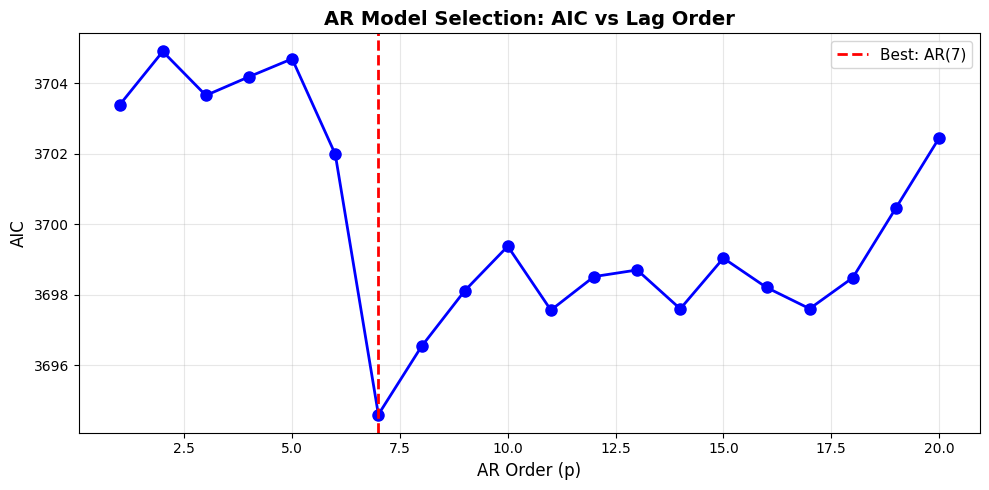


Top 5 AR models by AIC:
     p          aic          bic
6    7  3694.593540  3737.405932
7    8  3696.527707  3744.097031
10  11  3697.557969  3759.398090
13  14  3697.594397  3773.705315
16  17  3697.598941  3787.980656


In [9]:
# Visualize AR grid search results
ar_results_df = pd.DataFrame(ar_results)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ar_results_df['p'], ar_results_df['aic'], 'b-o', linewidth=2, markersize=8)
ax.axvline(x=best_ar_p, color='red', linestyle='--', linewidth=2, label=f'Best: AR({best_ar_p})')
ax.set_xlabel('AR Order (p)', fontsize=12)
ax.set_ylabel('AIC', fontsize=12)
ax.set_title('AR Model Selection: AIC vs Lag Order', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 AR models by AIC:")
print(ar_results_df.sort_values('aic').head())


## 2.3 Model Evaluation & Prediction Visualization


In [10]:
print(f"Evaluating AR({best_ar_p}) on test set with rolling forecast...")

# Rolling forecast with best AR model
ar_predictions = rolling_forecast(ts_train, ts_val, ts_test, order=(best_ar_p, 0, 0))

# Calculate metrics
ar_metrics = calculate_metrics(ts_test, ar_predictions)

print("\n" + "=" * 70)
print(f"AR({best_ar_p}) MODEL RESULTS")
print("=" * 70)
print_metrics(ar_metrics, f"AR({best_ar_p})")


Evaluating AR(7) on test set with rolling forecast...
  Processed 50/185 samples
  Processed 100/185 samples
  Processed 150/185 samples

AR(7) MODEL RESULTS

AR(7) Test Set Metrics:
  MSE:  1.9003
  RMSE: 1.3785
  MAE:  1.0009
  R²:   0.8587
  MAPE: 1.57%


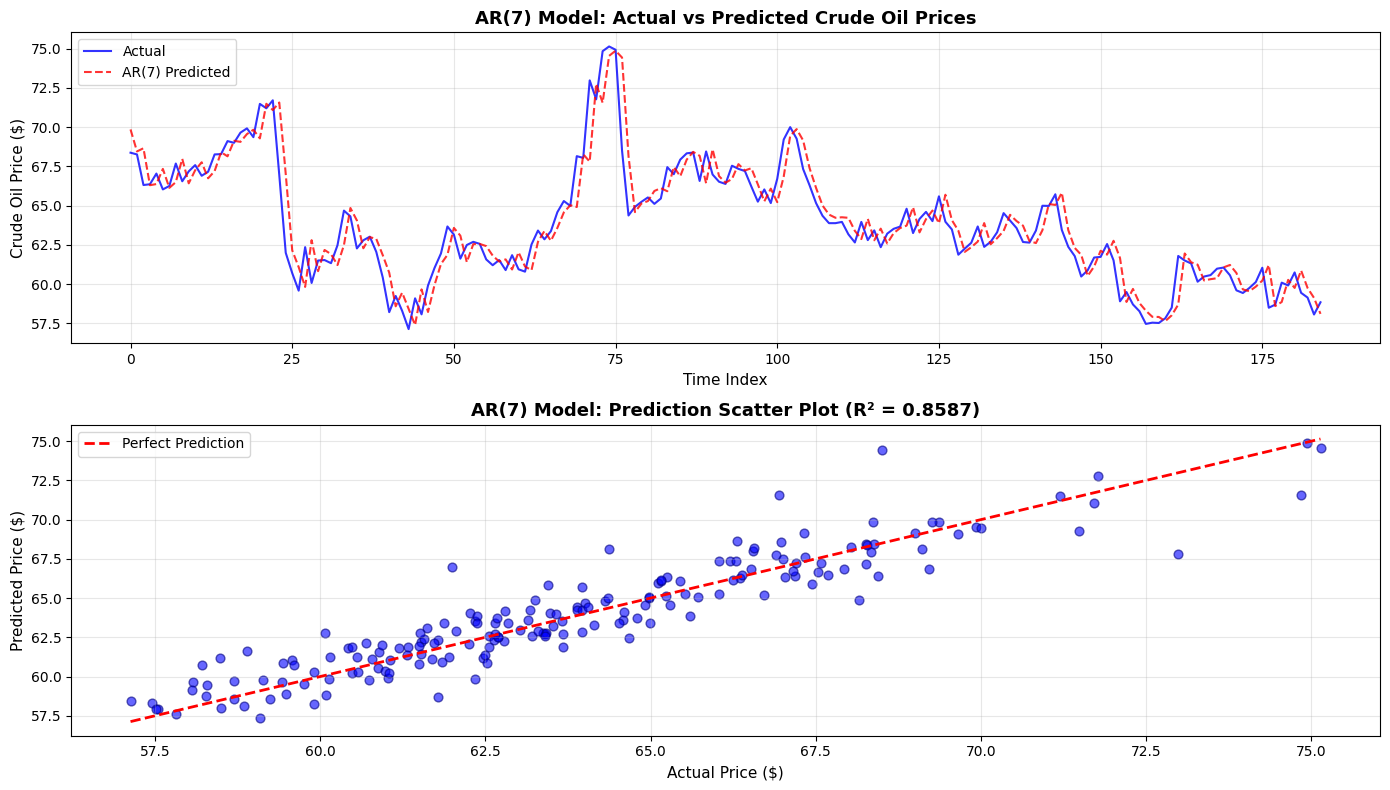

In [11]:
# Visualize AR predictions vs actual values
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Time series comparison
axes[0].plot(range(len(ts_test)), ts_test, 'b-', linewidth=1.5, label='Actual', alpha=0.8)
axes[0].plot(range(len(ar_predictions)), ar_predictions, 'r--', linewidth=1.5, label=f'AR({best_ar_p}) Predicted', alpha=0.8)
axes[0].set_xlabel('Time Index', fontsize=11)
axes[0].set_ylabel('Crude Oil Price ($)', fontsize=11)
axes[0].set_title(f'AR({best_ar_p}) Model: Actual vs Predicted Crude Oil Prices', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot with perfect prediction line
axes[1].scatter(ts_test, ar_predictions, alpha=0.6, c='blue', edgecolors='navy', s=40)
min_val = min(ts_test.min(), ar_predictions.min())
max_val = max(ts_test.max(), ar_predictions.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=11)
axes[1].set_ylabel('Predicted Price ($)', fontsize=11)
axes[1].set_title(f'AR({best_ar_p}) Model: Prediction Scatter Plot (R² = {ar_metrics["R2"]:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

# 3. MA (Moving Average) Model

The Moving Average model predicts future values based on a linear combination of past forecast errors:

$$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$$

where $q$ is the order (number of lagged errors) and $\theta_i$ are the moving average coefficients.

## 3.1 Hyperparameter Grid Search


In [12]:
print("=" * 70)
print("MA MODEL - HYPERPARAMETER GRID SEARCH")
print("=" * 70)

# Grid search over MA order q
MA_Q_RANGE = range(1, 21)  # Test MA(1) to MA(20)

ma_results = []
best_ma_aic = float('inf')
best_ma_q = None

print(f"\nSearching MA order q ∈ [{MA_Q_RANGE.start}, {MA_Q_RANGE.stop - 1}]...")
start_time = time.time()

for q in MA_Q_RANGE:
    try:
        # MA(q) = ARIMA(0, 0, q)
        model = ARIMA(ts_train, order=(0, 0, q))
        fitted = model.fit()
        
        ma_results.append({
            'q': q,
            'aic': fitted.aic,
            'bic': fitted.bic
        })
        
        if fitted.aic < best_ma_aic:
            best_ma_aic = fitted.aic
            best_ma_q = q
            
    except Exception as e:
        continue

elapsed = time.time() - start_time
print(f"Grid search completed in {elapsed:.2f} seconds")
print(f"Best MA order: q = {best_ma_q}")
print(f"   Best AIC: {best_ma_aic:.2f}")


MA MODEL - HYPERPARAMETER GRID SEARCH

Searching MA order q ∈ [1, 20]...
Grid search completed in 14.28 seconds
Best MA order: q = 20
   Best AIC: 3836.28


## 3.2 Grid Search Visualization


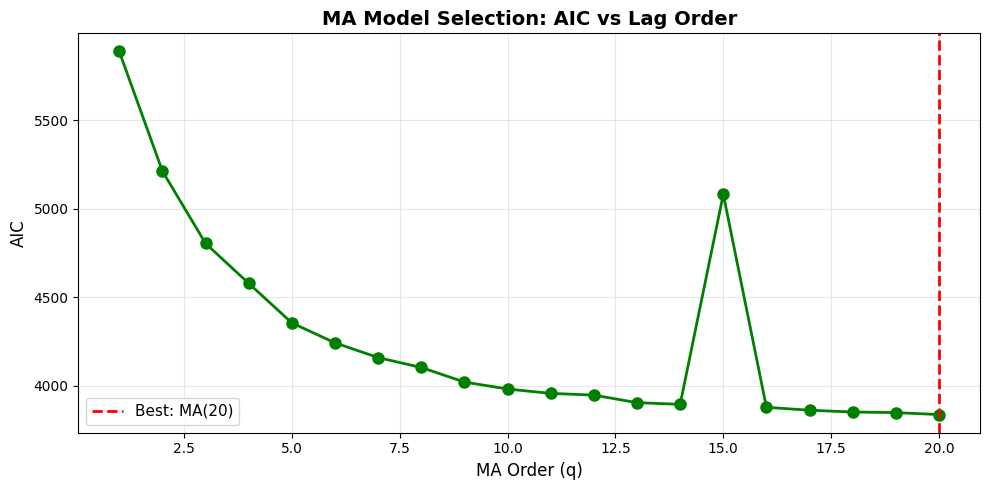


Top 5 MA models by AIC:
     q          aic          bic
19  20  3836.284243  3940.936756
18  19  3847.407888  3947.303468
17  18  3850.696128  3945.834776
16  17  3860.930717  3951.312433
15  16  3877.314682  3962.939465


In [13]:
# Visualize MA grid search results
ma_results_df = pd.DataFrame(ma_results)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ma_results_df['q'], ma_results_df['aic'], 'g-o', linewidth=2, markersize=8)
ax.axvline(x=best_ma_q, color='red', linestyle='--', linewidth=2, label=f'Best: MA({best_ma_q})')
ax.set_xlabel('MA Order (q)', fontsize=12)
ax.set_ylabel('AIC', fontsize=12)
ax.set_title('MA Model Selection: AIC vs Lag Order', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 MA models by AIC:")
print(ma_results_df.sort_values('aic').head())


## 3.3 Model Evaluation & Prediction Visualization


In [14]:
print(f"Evaluating MA({best_ma_q}) on test set with rolling forecast...")

# Rolling forecast with best MA model
ma_predictions = rolling_forecast(ts_train, ts_val, ts_test, order=(0, 0, best_ma_q))

# Calculate metrics
ma_metrics = calculate_metrics(ts_test, ma_predictions)

print("\n" + "=" * 70)
print(f"MA({best_ma_q}) MODEL RESULTS")
print("=" * 70)
print_metrics(ma_metrics, f"MA({best_ma_q})")


Evaluating MA(20) on test set with rolling forecast...
  Processed 50/185 samples
  Processed 100/185 samples
  Processed 150/185 samples

MA(20) MODEL RESULTS

MA(20) Test Set Metrics:
  MSE:  3.1296
  RMSE: 1.7691
  MAE:  1.3111
  R²:   0.7673
  MAPE: 2.06%


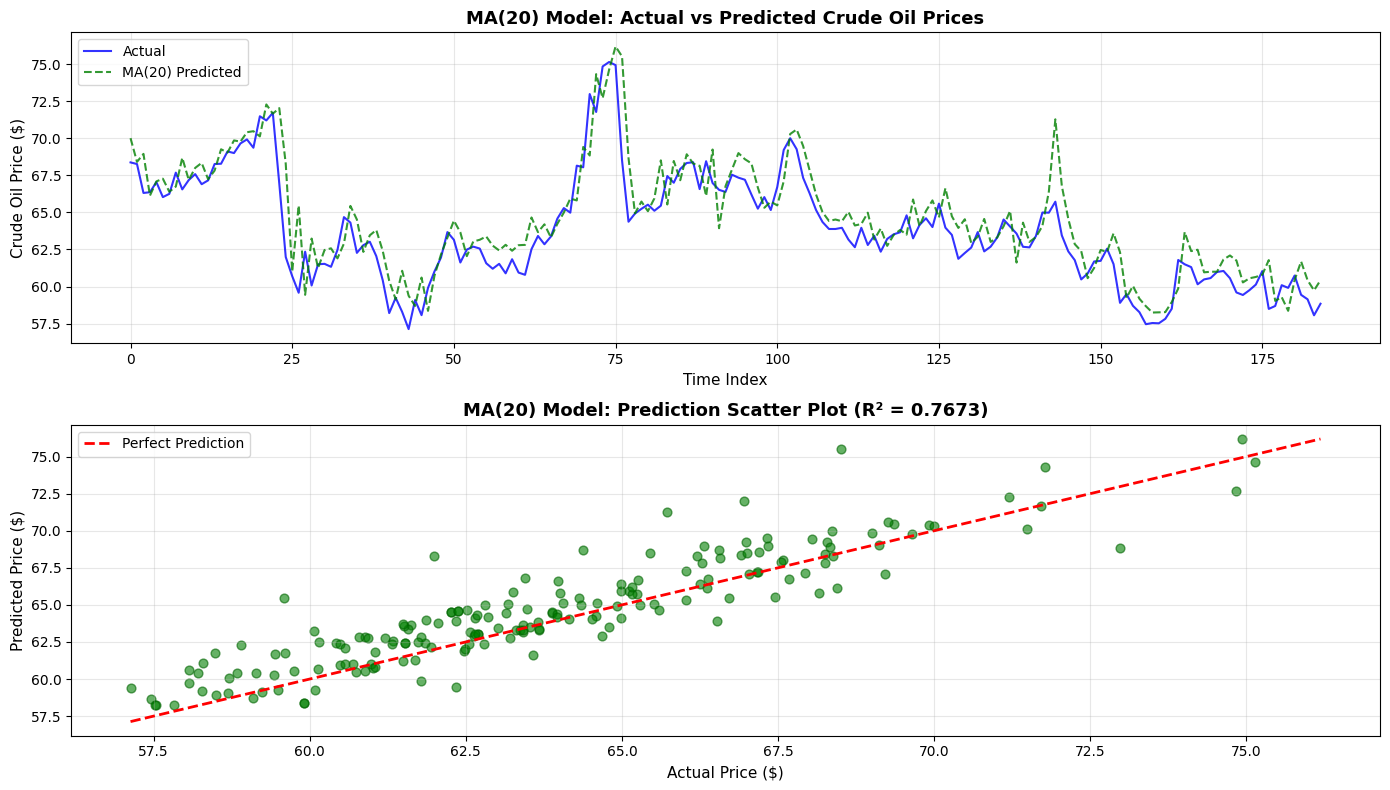

In [15]:
# Visualize MA predictions vs actual values
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Time series comparison
axes[0].plot(range(len(ts_test)), ts_test, 'b-', linewidth=1.5, label='Actual', alpha=0.8)
axes[0].plot(range(len(ma_predictions)), ma_predictions, 'g--', linewidth=1.5, label=f'MA({best_ma_q}) Predicted', alpha=0.8)
axes[0].set_xlabel('Time Index', fontsize=11)
axes[0].set_ylabel('Crude Oil Price ($)', fontsize=11)
axes[0].set_title(f'MA({best_ma_q}) Model: Actual vs Predicted Crude Oil Prices', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot with perfect prediction line
axes[1].scatter(ts_test, ma_predictions, alpha=0.6, c='green', edgecolors='darkgreen', s=40)
min_val = min(ts_test.min(), ma_predictions.min())
max_val = max(ts_test.max(), ma_predictions.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=11)
axes[1].set_ylabel('Predicted Price ($)', fontsize=11)
axes[1].set_title(f'MA({best_ma_q}) Model: Prediction Scatter Plot (R² = {ma_metrics["R2"]:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

# 4. ARIMA (AutoRegressive Integrated Moving Average) Model

The ARIMA model combines autoregression (AR), differencing (I), and moving average (MA) components:

$$y'_t = c + \phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$$

where $y'_t$ is the differenced series (applied $d$ times), $p$ is the AR order, $d$ is the differencing order, and $q$ is the MA order.

## 4.1 Hyperparameter Grid Search


In [16]:
print("=" * 70)
print("ARIMA MODEL - HYPERPARAMETER GRID SEARCH")
print("=" * 70)

# Grid search over ARIMA(p, d, q)
P_VALUES = range(0, 8)  # AR order
D_VALUES = range(0, 3)  # Differencing order  
Q_VALUES = range(0, 8)  # MA order

print(f"\nSearch space:")
print(f"  p ∈ {list(P_VALUES)}")
print(f"  d ∈ {list(D_VALUES)}")
print(f"  q ∈ {list(Q_VALUES)}")
print(f"  Total combinations: {len(P_VALUES) * len(D_VALUES) * len(Q_VALUES)}")

arima_results = []
best_arima_aic = float('inf')
best_arima_order = None

start_time = time.time()

for p in P_VALUES:
    for d in D_VALUES:
        for q in Q_VALUES:
            try:
                model = ARIMA(ts_train, order=(p, d, q))
                fitted = model.fit()
                
                arima_results.append({
                    'order': (p, d, q),
                    'p': p,
                    'd': d,
                    'q': q,
                    'aic': fitted.aic,
                    'bic': fitted.bic
                })
                
                if fitted.aic < best_arima_aic:
                    best_arima_aic = fitted.aic
                    best_arima_order = (p, d, q)
                    
            except Exception as e:
                continue

elapsed = time.time() - start_time
print(f"\nGrid search completed in {elapsed:.2f} seconds")
print(f"Evaluated {len(arima_results)} valid combinations")
print(f"Best ARIMA order: {best_arima_order}")
print(f"   Best AIC: {best_arima_aic:.2f}")


ARIMA MODEL - HYPERPARAMETER GRID SEARCH

Search space:
  p ∈ [0, 1, 2, 3, 4, 5, 6, 7]
  d ∈ [0, 1, 2]
  q ∈ [0, 1, 2, 3, 4, 5, 6, 7]
  Total combinations: 192

Grid search completed in 42.79 seconds
Evaluated 192 valid combinations
Best ARIMA order: (5, 1, 5)
   Best AIC: 3667.27


## 4.2 Grid Search Visualization


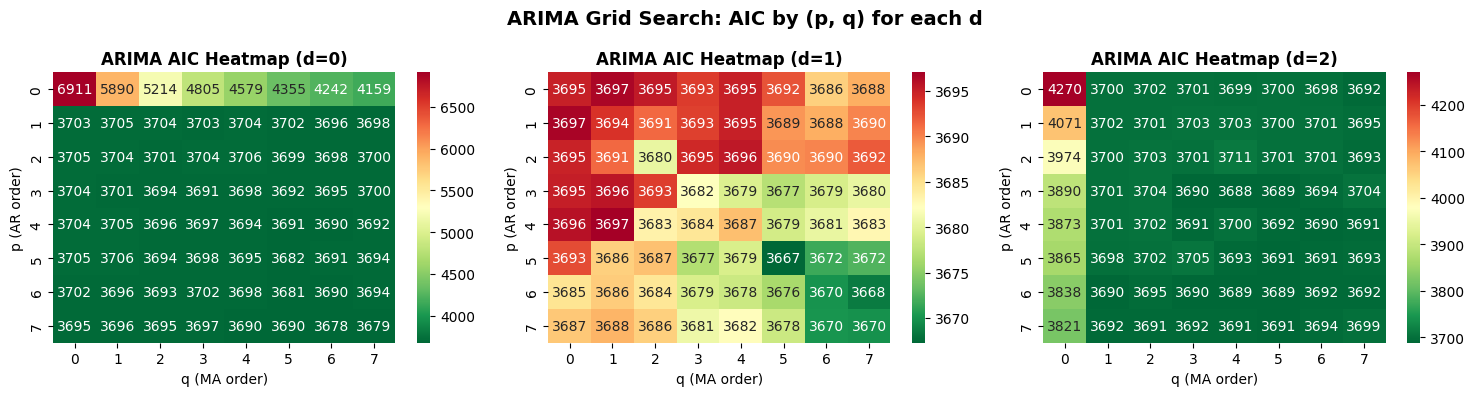


Top 10 ARIMA models by AIC:
         order          aic          bic
133  (5, 1, 5)  3667.273501  3719.586959
159  (6, 1, 7)  3668.457650  3735.038415
183  (7, 1, 7)  3669.926255  3741.262789
158  (6, 1, 6)  3670.044595  3731.869591
182  (7, 1, 6)  3670.107360  3736.688125
134  (5, 1, 6)  3671.660511  3728.729738
135  (5, 1, 7)  3672.411334  3734.236330
157  (6, 1, 5)  3676.426334  3733.495561
131  (5, 1, 3)  3676.967983  3719.769903
85   (3, 1, 5)  3677.258270  3720.060191


In [17]:
# Visualize ARIMA grid search results
arima_results_df = pd.DataFrame(arima_results)

# Heatmaps for each d value
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, d_val in enumerate(D_VALUES):
    df_d = arima_results_df[arima_results_df['d'] == d_val]
    if len(df_d) > 0:
        pivot = df_d.pivot_table(values='aic', index='p', columns='q', aggfunc='mean')
        sns.heatmap(pivot, ax=axes[idx], cmap='RdYlGn_r', annot=True, fmt='.0f', cbar=True)
        axes[idx].set_title(f'ARIMA AIC Heatmap (d={d_val})', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('q (MA order)')
        axes[idx].set_ylabel('p (AR order)')

plt.suptitle('ARIMA Grid Search: AIC by (p, q) for each d', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 10 ARIMA models by AIC:")
print(arima_results_df.sort_values('aic').head(10)[['order', 'aic', 'bic']])


## 4.3 Model Evaluation & Prediction Visualization


In [18]:
print(f"Evaluating ARIMA{best_arima_order} on test set with rolling forecast...")

# Rolling forecast with best ARIMA model
arima_predictions = rolling_forecast(ts_train, ts_val, ts_test, order=best_arima_order)

# Calculate metrics
arima_metrics = calculate_metrics(ts_test, arima_predictions)

print("\n" + "=" * 70)
print(f"ARIMA{best_arima_order} MODEL RESULTS")
print("=" * 70)
print_metrics(arima_metrics, f"ARIMA{best_arima_order}")


Evaluating ARIMA(5, 1, 5) on test set with rolling forecast...
  Processed 50/185 samples
  Processed 100/185 samples
  Processed 150/185 samples

ARIMA(5, 1, 5) MODEL RESULTS

ARIMA(5, 1, 5) Test Set Metrics:
  MSE:  1.8868
  RMSE: 1.3736
  MAE:  0.9772
  R²:   0.8597
  MAPE: 1.53%


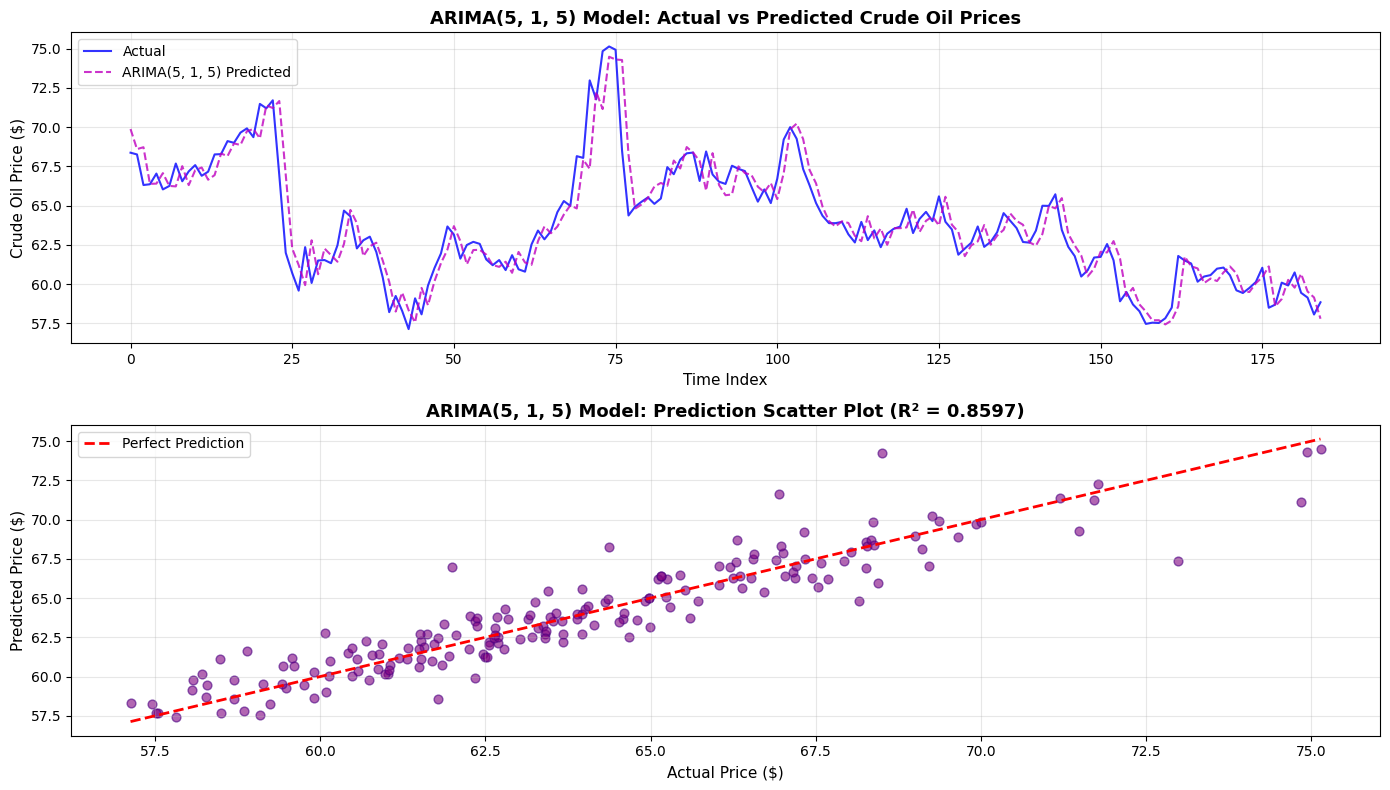

In [19]:
# Visualize ARIMA predictions vs actual values
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Time series comparison
axes[0].plot(range(len(ts_test)), ts_test, 'b-', linewidth=1.5, label='Actual', alpha=0.8)
axes[0].plot(range(len(arima_predictions)), arima_predictions, 'm--', linewidth=1.5, label=f'ARIMA{best_arima_order} Predicted', alpha=0.8)
axes[0].set_xlabel('Time Index', fontsize=11)
axes[0].set_ylabel('Crude Oil Price ($)', fontsize=11)
axes[0].set_title(f'ARIMA{best_arima_order} Model: Actual vs Predicted Crude Oil Prices', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot with perfect prediction line
axes[1].scatter(ts_test, arima_predictions, alpha=0.6, c='purple', edgecolors='indigo', s=40)
min_val = min(ts_test.min(), arima_predictions.min())
max_val = max(ts_test.max(), arima_predictions.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=11)
axes[1].set_ylabel('Predicted Price ($)', fontsize=11)
axes[1].set_title(f'ARIMA{best_arima_order} Model: Prediction Scatter Plot (R² = {arima_metrics["R2"]:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

# 5. Model Comparison and Summary

This section provides a comprehensive comparison of all time series models evaluated in this notebook.


In [20]:
# Create model comparison summary
print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

# Compile results
comparison_data = {
    'Model': ['Naive Baseline', f'AR({best_ar_p})', f'MA({best_ma_q})', f'ARIMA{best_arima_order}'],
    'MSE': [naive_metrics['MSE'], ar_metrics['MSE'], ma_metrics['MSE'], arima_metrics['MSE']],
    'RMSE': [naive_metrics['RMSE'], ar_metrics['RMSE'], ma_metrics['RMSE'], arima_metrics['RMSE']],
    'MAE': [naive_metrics['MAE'], ar_metrics['MAE'], ma_metrics['MAE'], arima_metrics['MAE']],
    'R²': [naive_metrics['R2'], ar_metrics['R2'], ma_metrics['R2'], arima_metrics['R2']],
    'MAPE (%)': [naive_metrics['MAPE'], ar_metrics['MAPE'], ma_metrics['MAPE'], arima_metrics['MAPE']]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

# Display with formatting
print("\n📊 Performance Metrics Summary:\n")
print(comparison_df.round(4).to_string())

# Identify best model
best_model_idx = comparison_df['RMSE'].idxmin()
print(f"Best Model by RMSE: {best_model_idx} (RMSE = {comparison_df.loc[best_model_idx, 'RMSE']:.4f})")


MODEL COMPARISON SUMMARY

📊 Performance Metrics Summary:

                   MSE    RMSE     MAE      R²  MAPE (%)
Model                                                   
Naive Baseline  1.8973  1.3774  0.9830  0.8585    1.5365
AR(7)           1.9003  1.3785  1.0009  0.8587    1.5657
MA(20)          3.1296  1.7691  1.3111  0.7673    2.0632
ARIMA(5, 1, 5)  1.8868  1.3736  0.9772  0.8597    1.5258
Best Model by RMSE: ARIMA(5, 1, 5) (RMSE = 1.3736)


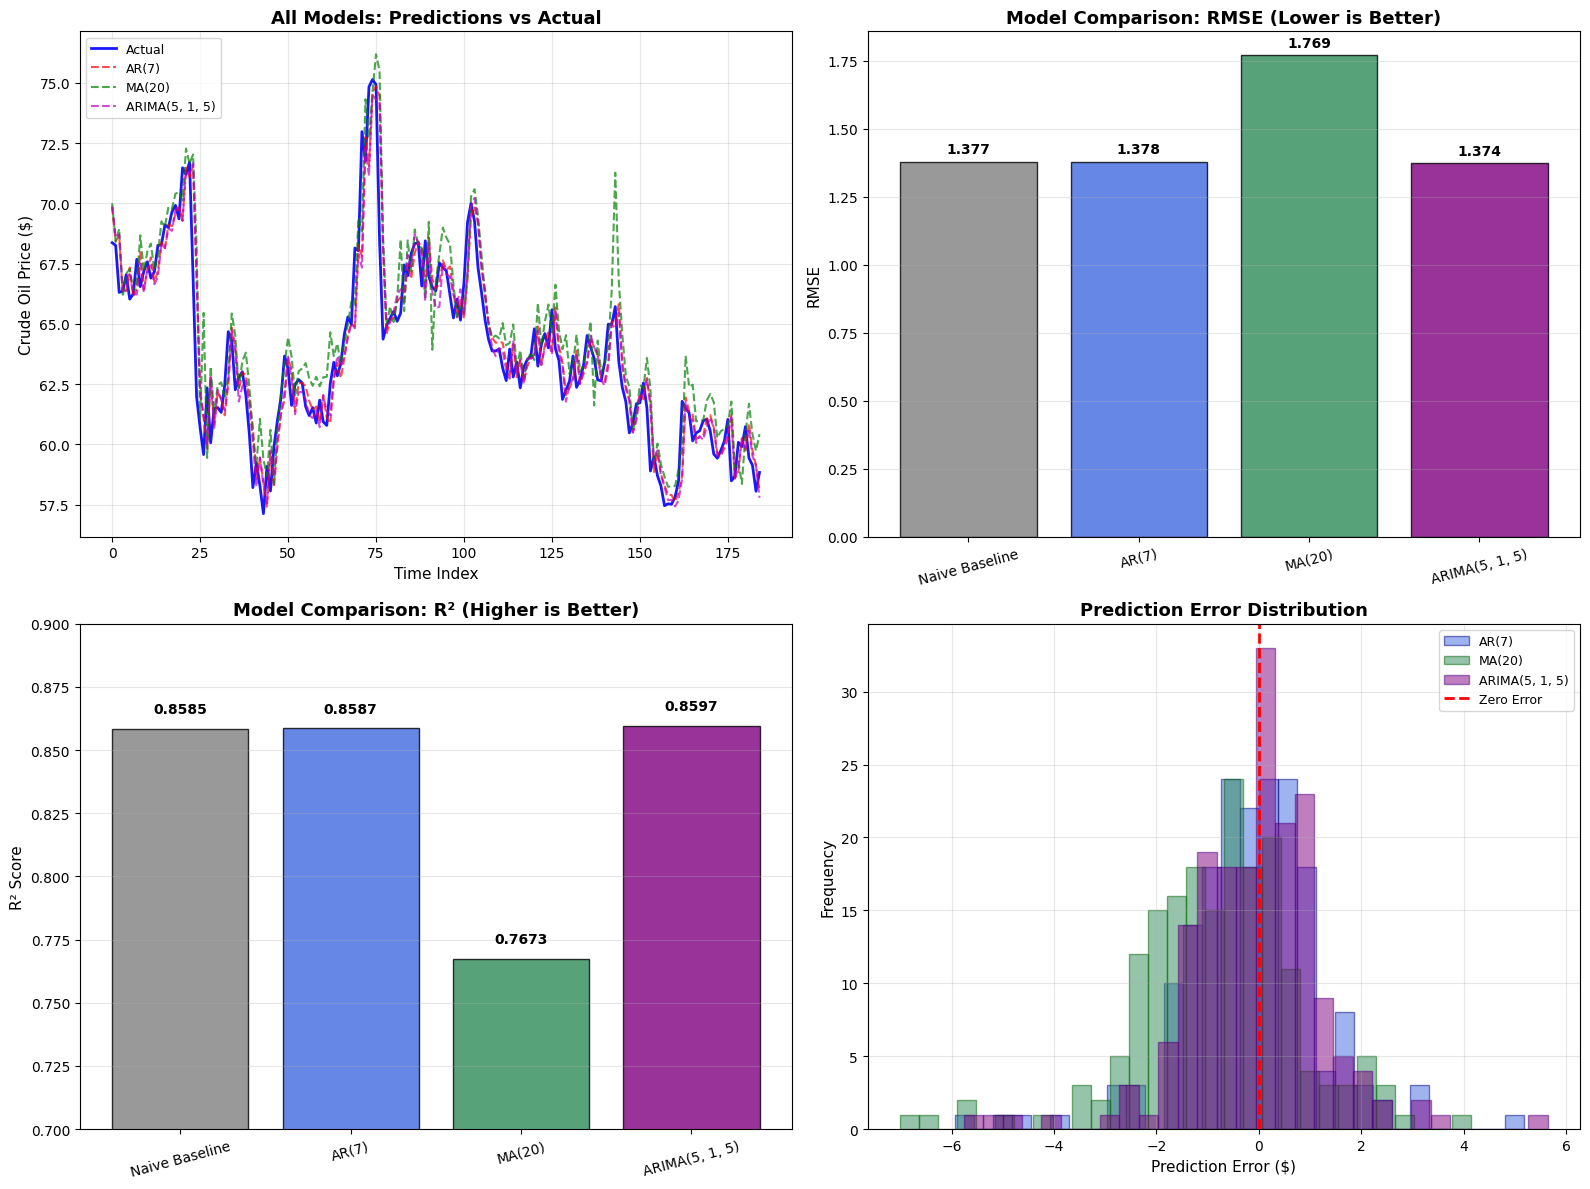

In [21]:
# Comprehensive visualization of all model predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All predictions comparison
ax1 = axes[0, 0]
ax1.plot(range(len(ts_test)), ts_test, 'b-', linewidth=2, label='Actual', alpha=0.9)
ax1.plot(range(len(ar_predictions)), ar_predictions, 'r--', linewidth=1.5, label=f'AR({best_ar_p})', alpha=0.7)
ax1.plot(range(len(ma_predictions)), ma_predictions, 'g--', linewidth=1.5, label=f'MA({best_ma_q})', alpha=0.7)
ax1.plot(range(len(arima_predictions)), arima_predictions, 'm--', linewidth=1.5, label=f'ARIMA{best_arima_order}', alpha=0.7)
ax1.set_xlabel('Time Index', fontsize=11)
ax1.set_ylabel('Crude Oil Price ($)', fontsize=11)
ax1.set_title('All Models: Predictions vs Actual', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Model performance bar chart (RMSE)
ax2 = axes[0, 1]
models = comparison_df.index.tolist()
rmse_values = comparison_df['RMSE'].values
colors = ['gray', 'royalblue', 'seagreen', 'purple']
bars = ax2.bar(models, rmse_values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('RMSE', fontsize=11)
ax2.set_title('Model Comparison: RMSE (Lower is Better)', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, rmse_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: R² comparison
ax3 = axes[1, 0]
r2_values = comparison_df['R²'].values
bars = ax3.bar(models, r2_values, color=colors, edgecolor='black', alpha=0.8)
ax3.set_ylabel('R² Score', fontsize=11)
ax3.set_title('Model Comparison: R² (Higher is Better)', fontsize=13, fontweight='bold')
ax3.tick_params(axis='x', rotation=15)
ax3.set_ylim([0.7, 0.9])
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, r2_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Prediction error distribution
ax4 = axes[1, 1]
ar_errors = ts_test - ar_predictions
ma_errors = ts_test - ma_predictions
arima_errors = ts_test - arima_predictions

ax4.hist(ar_errors, bins=30, alpha=0.5, label=f'AR({best_ar_p})', color='royalblue', edgecolor='navy')
ax4.hist(ma_errors, bins=30, alpha=0.5, label=f'MA({best_ma_q})', color='seagreen', edgecolor='darkgreen')
ax4.hist(arima_errors, bins=30, alpha=0.5, label=f'ARIMA{best_arima_order}', color='purple', edgecolor='indigo')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.set_xlabel('Prediction Error ($)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
